In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2

In [2]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

In [4]:
import os

# Function to extract file paths and labels, skipping hidden files like .DS_Store
def extract_filepaths_and_labels(data_dir):
    filepaths = []
    labels = []
    classes = os.listdir(data_dir)  # List all class folders
    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        
        # Skip hidden files like .DS_Store and process only directories
        if not class_name.startswith('.') and os.path.isdir(class_path):
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                
                # Skip hidden files in the subdirectories as well
                if not file.startswith('.'):
                    filepaths.append(file_path)
                    labels.append(class_name)  # Use class name as label
    return filepaths, labels

# Define the dataset directory paths
train_data_dir = "./dataset/training/"
test_data_dir = "./dataset/testing/"

# Extract training file paths and labels
train_filepaths, train_labels = extract_filepaths_and_labels(train_data_dir)

# Extract testing file paths and labels
test_filepaths, test_labels = extract_filepaths_and_labels(test_data_dir)

# Optionally, you can print sample outputs to verify
print("Sample training file paths and labels:")
for i in range(5):  # Print the first 5 training file paths and labels
    print(f"File: {train_filepaths[i]}, Label: {train_labels[i]}")

print("\nSample testing file paths and labels:")
for i in range(5):  # Print the first 5 testing file paths and labels
    print(f"File: {test_filepaths[i]}, Label: {test_labels[i]}")

Sample training file paths and labels:
File: ./dataset/training/pituitary/Tr-pi_0505.jpg, Label: pituitary
File: ./dataset/training/pituitary/Tr-pi_0263.jpg, Label: pituitary
File: ./dataset/training/pituitary/Tr-pi_0277.jpg, Label: pituitary
File: ./dataset/training/pituitary/Tr-pi_1169.jpg, Label: pituitary
File: ./dataset/training/pituitary/Tr-pi_0511.jpg, Label: pituitary

Sample testing file paths and labels:
File: ./dataset/testing/pituitary/Te-pi_0233.jpg, Label: pituitary
File: ./dataset/testing/pituitary/Te-pi_0227.jpg, Label: pituitary
File: ./dataset/testing/pituitary/Te-pi_0019.jpg, Label: pituitary
File: ./dataset/testing/pituitary/Te-pi_0031.jpg, Label: pituitary
File: ./dataset/testing/pituitary/Te-pi_0025.jpg, Label: pituitary


In [5]:
# List all classes (subdirectories) in the training directory
train_data_dir = "./dataset/training/"
classes = os.listdir(train_data_dir)

classes.remove(".DS_Store")
print(classes)

['pituitary', 'notumor', 'glioma', 'meningioma']


In [6]:
import pandas as pd

# Concatenate training data paths with labels into one dataframe
Fseries_train = pd.Series(train_filepaths, name="filepaths")
Lseries_train = pd.Series(train_labels, name="labels")
train_df = pd.concat([Fseries_train, Lseries_train], axis=1)

# Concatenate testing data paths with labels into one dataframe
Fseries_test = pd.Series(test_filepaths, name="filepaths")
Lseries_test = pd.Series(test_labels, name="labels")
test_df = pd.concat([Fseries_test, Lseries_test], axis=1)

In [7]:
# valid and test dataframe
valid_df, test_df = train_test_split(test_df, shuffle=True, test_size= .5, random_state= 123)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# crobed image size
batch_size = 12
img_size = (224,224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

In [15]:
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


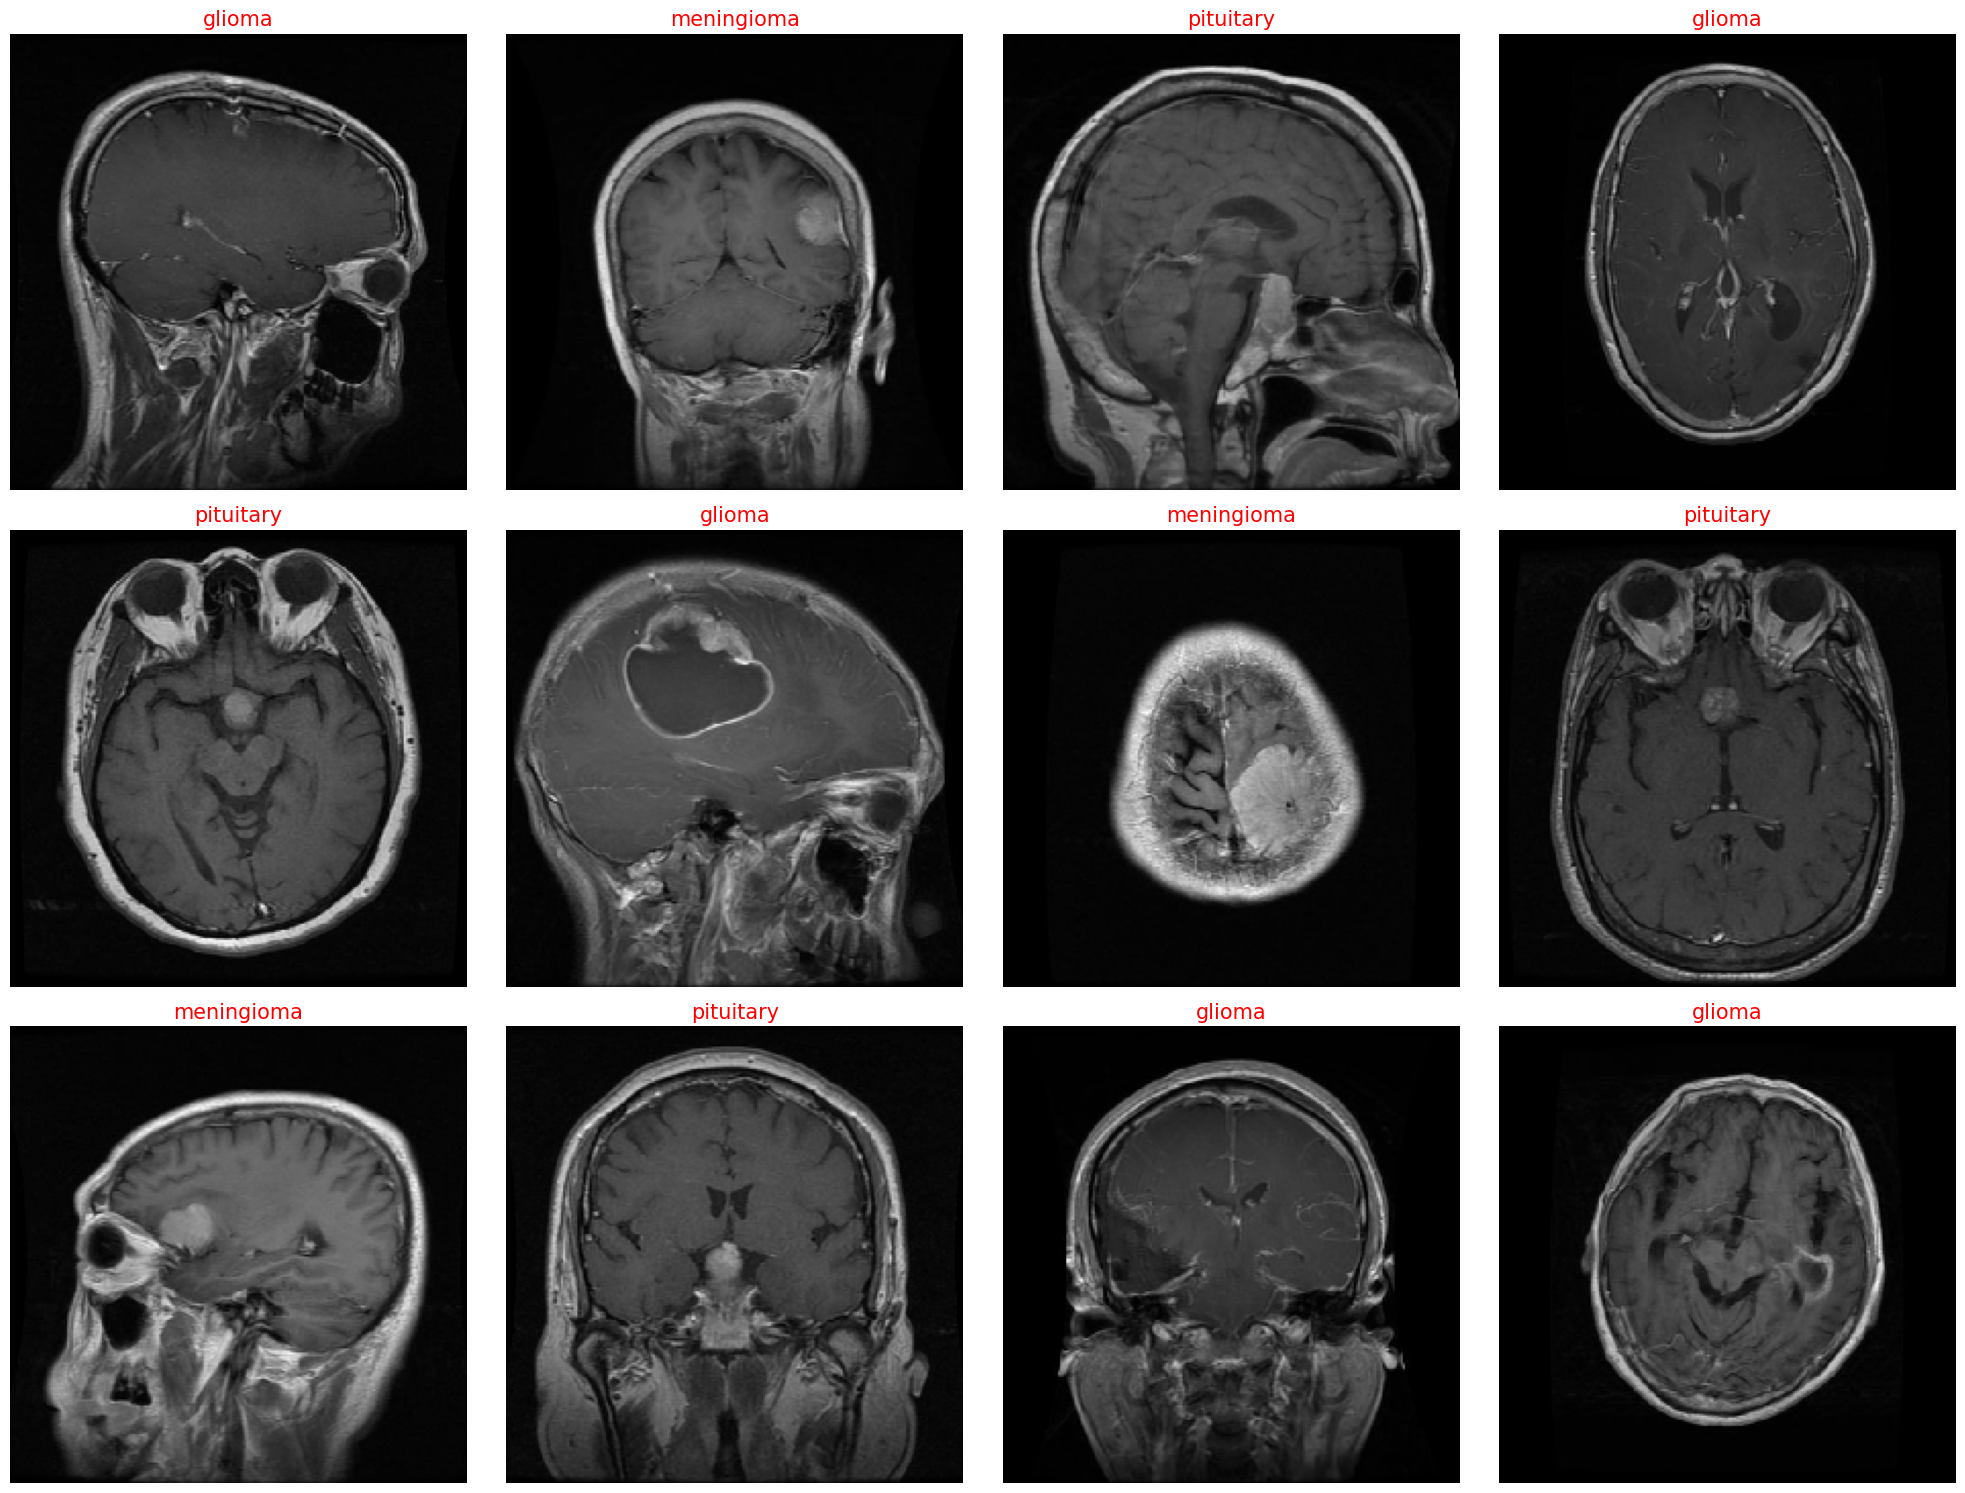

In [17]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())         # defines list of dictionary's keys (class names)
images, labels = next(train_gen)      # get a batch of samples from the generator

plt.figure(figsize=(20, 20))

# Get the actual number of images in the batch
num_images = len(images)
num_to_display = min(16, num_images)  # Display up to 16 images or fewer if not enough

for i in range(num_to_display):
    plt.subplot(4, 4, i+1)
    image = images[i] / 255.0         # scales data to range (0 - 1)
    plt.imshow(image)
    
    index = np.argmax(labels[i])      # get the index of the class with the highest probability
    class_name = classes[index]       # get the class name corresponding to the index
    plt.title(class_name, color='red', fontsize=15)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [19]:
# Create Model Structure
img_size = (224,224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

In [21]:
model = Sequential([
    Conv2D(filters= 64, kernel_size=(3,3), activation= 'relu', padding='same', input_shape= img_shape),
    Conv2D(filters= 64, kernel_size=(3,3), activation= 'relu', padding='same'),
    MaxPooling2D((2,2)),

    Conv2D(filters= 128, kernel_size=(3,3), activation= 'relu', padding='same'),
    Conv2D(filters= 128, kernel_size=(3,3), activation= 'relu', padding='same'),
    MaxPooling2D((2,2)),

    Conv2D(filters= 256, kernel_size=(3,3), activation= 'relu', padding='same'),
    Conv2D(filters= 256, kernel_size=(3,3), activation= 'relu', padding='same'),
    Conv2D(filters= 256, kernel_size=(3,3), activation= 'relu', padding='same'),
    MaxPooling2D((2,2)),

    Conv2D(filters= 512, kernel_size=(3,3), activation= 'relu', padding='same'),
    Conv2D(filters= 512, kernel_size=(3,3), activation= 'relu', padding='same'),
    Conv2D(filters= 512, kernel_size=(3,3), activation= 'relu', padding='same'),
    MaxPooling2D((2,2)),

    Conv2D(filters= 512, kernel_size=(3,3), activation= 'relu', padding='same'),
    Conv2D(filters= 512, kernel_size=(3,3), activation= 'relu', padding='same'),
    Conv2D(filters= 512, kernel_size=(3,3), activation= 'relu', padding='same'),
    MaxPooling2D((2,2)),

    Flatten(),
    
    Dense(256, activation = "relu"),
    Dense(64, activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= .0001), loss = 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-06 17:22:22.388619: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-10-06 17:22:22.388647: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-10-06 17:22:22.388653: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-10-06 17:22:22.388696: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-06 17:22:22.388711: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Creat

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,154,180 (80.70 MB)

 Trainable params: 21,154,180 (80.70 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
import tensorflow as tf

epochs = 10   
history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Num GPUs Available:  1
Epoch 1/10


2024-10-06 17:22:34.881682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/opt/anaconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


476/476 ━━━━━━━━━━━━━━━━━━━━ 292s 604ms/step - accuracy: 0.6091 - loss: 0.8873 - val_accuracy: 0.7405 - val_loss: 0.6573
Epoch 2/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 327s 687ms/step - accuracy: 0.8188 - loss: 0.4500 - val_accuracy: 0.8275 - val_loss: 0.4503
Epoch 3/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 703s 1s/step - accuracy: 0.8707 - loss: 0.3362 - val_accuracy: 0.7924 - val_loss: 0.4740
Epoch 4/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 453s 951ms/step - accuracy: 0.9256 - loss: 0.2052 - val_accuracy: 0.8901 - val_loss: 0.2798
Epoch 5/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 468s 984ms/step - accuracy: 0.9508 - loss: 0.1470 - val_accuracy: 0.9115 - val_loss: 0.2419
Epoch 6/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 436s 916ms/step - accuracy: 0.9706 - loss: 0.0955 - val_accuracy: 0.9542 - val_loss: 0.1538
Epoch 7/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 453s 953ms/step - accuracy: 0.9790 - loss: 0.0565 - val_accuracy: 0.9038 - val_loss: 0.2853
Epoch 8/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 459s 963ms/step - accuracy: 0.9844 - loss: 0.0470 

In [25]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

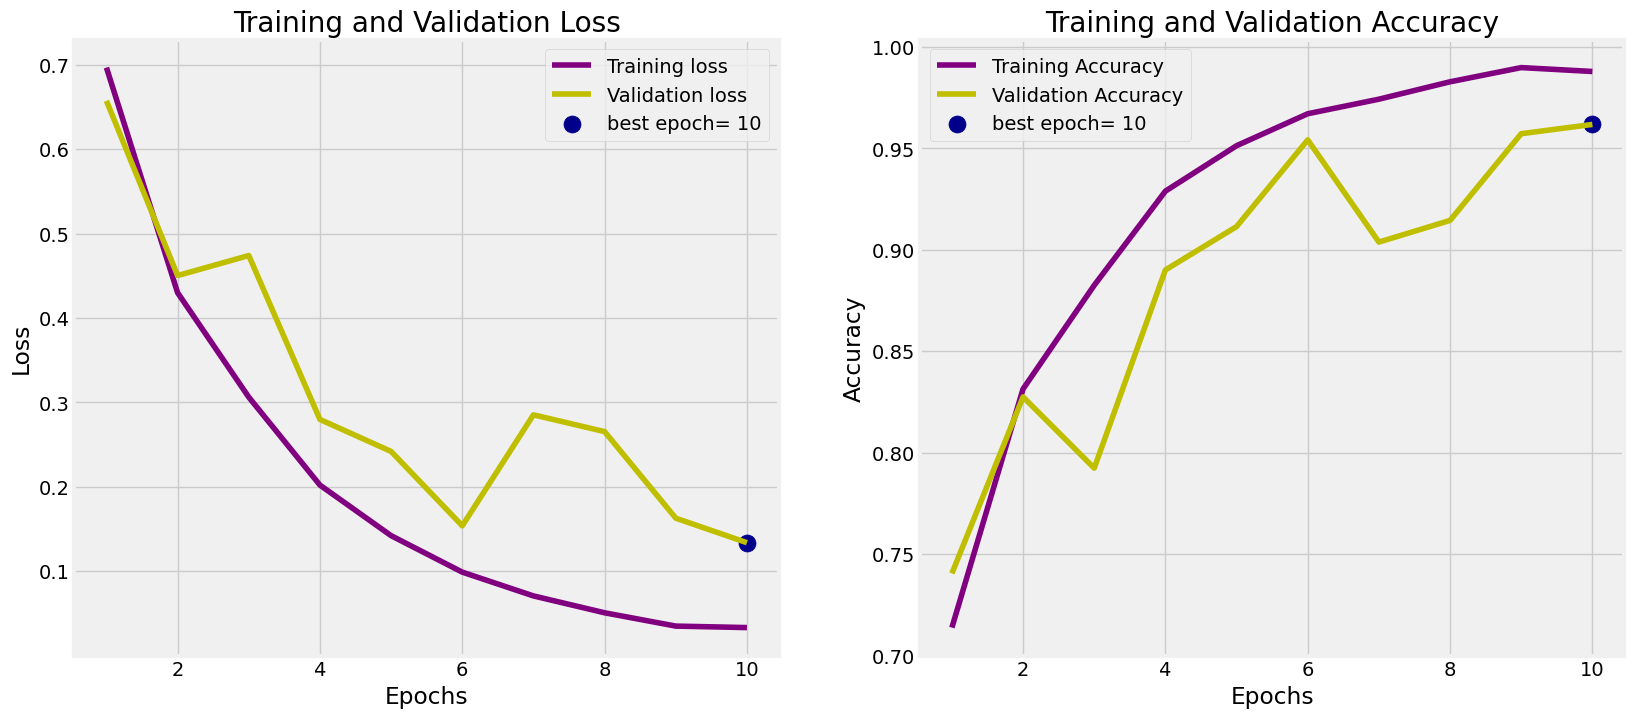

In [27]:
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'purple', label= 'Training loss')
plt.plot(Epochs, val_loss, 'y', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'darkblue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'purple', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'y', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'darkblue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [29]:
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

476/476 ━━━━━━━━━━━━━━━━━━━━ 68s 144ms/step - accuracy: 0.9923 - loss: 0.0262
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.9534 - loss: 0.1719
 1/55 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 1.0000 - loss: 3.7331e-04

/opt/anaconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.9579 - loss: 0.1459
Train Loss:  0.02743220143020153
Train Accuracy:  0.9917716979980469
--------------------
Validation Loss:  0.1338246762752533
Validation Accuracy:  0.9618320465087891
--------------------
Test Loss:  0.1436389982700348
Test Accuracy:  0.9588414430618286


In [31]:
pred = model.predict(test_gen)    # [[0.001, 0.97, 0.01, 0.009], [], [], ]
y_pred = np.argmax(pred, axis=1)

55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step


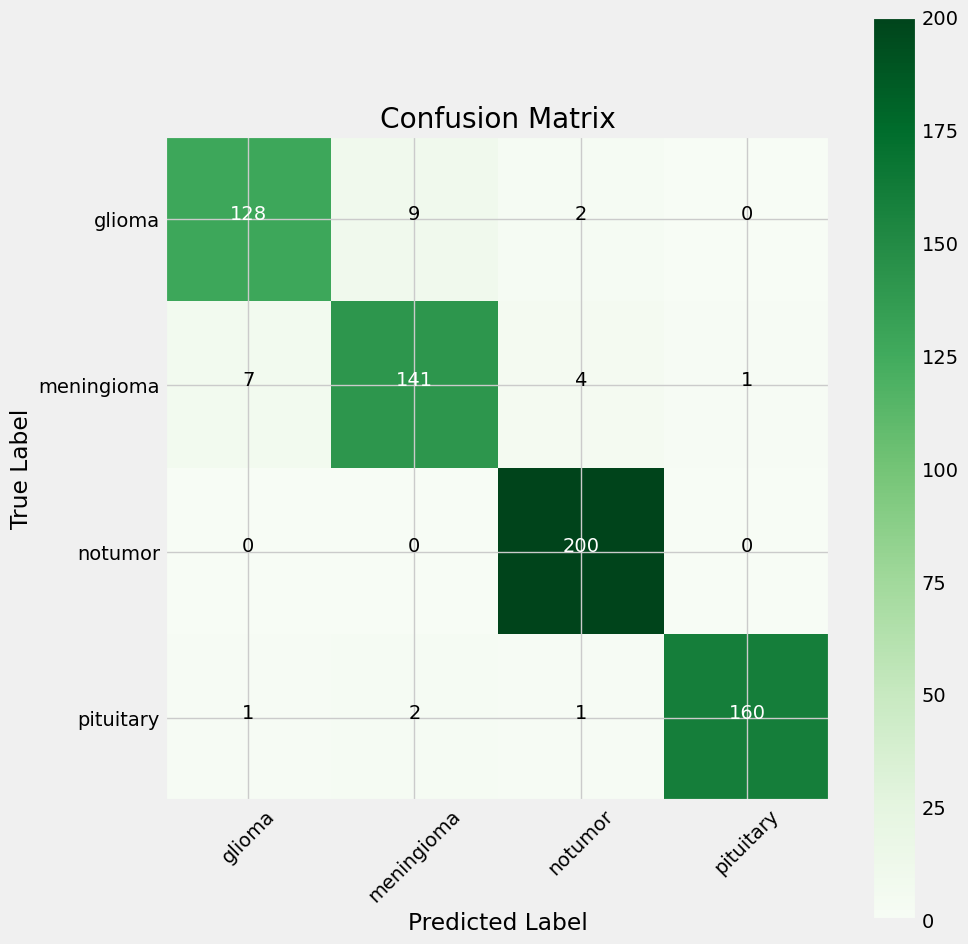

In [37]:
from sklearn.metrics import confusion_matrix
import itertools

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [39]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.94      0.92      0.93       139
  meningioma       0.93      0.92      0.92       153
     notumor       0.97      1.00      0.98       200
   pituitary       0.99      0.98      0.98       164

    accuracy                           0.96       656
   macro avg       0.96      0.95      0.96       656
weighted avg       0.96      0.96      0.96       656



In [71]:
# Save the model in a different directory (e.g., in a 'models' folder)
model.save('./models/Brain_Tumors.h5')

# Load the model from the new directory
loaded_model = tf.keras.models.load_model('./models/Brain_Tumors.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= .0001), loss = 'categorical_crossentropy', metrics= ['accuracy'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


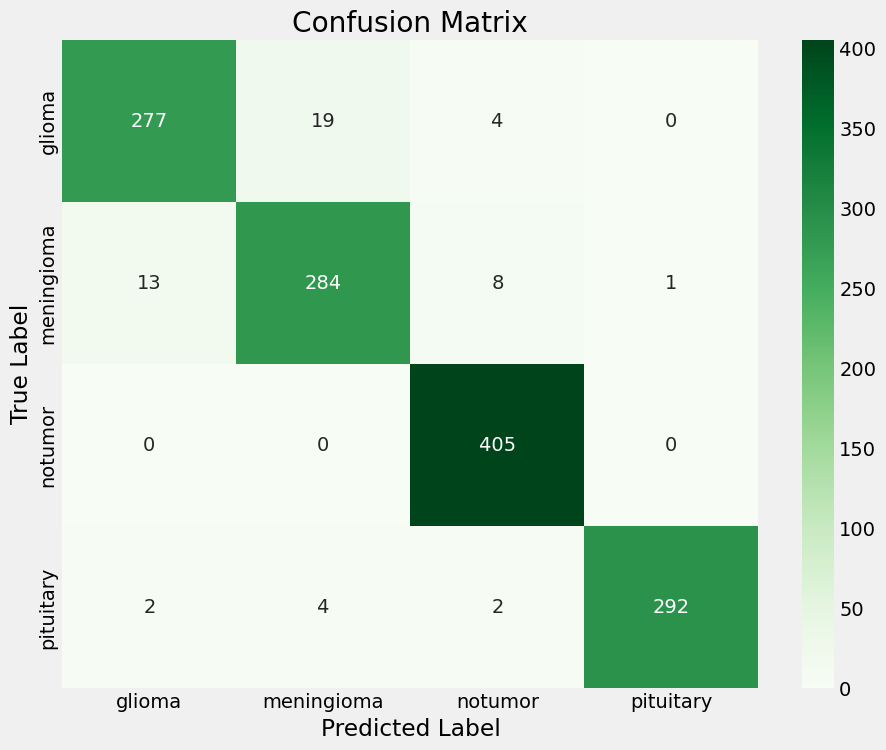

In [83]:
import os
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set the path to the test directory
test_dir = "./dataset/testing/"

# List of class labels (modify based on your model's output)
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Variables to calculate accuracy and confusion matrix
correct_predictions = 0
total_images = 0
true_labels = []
predicted_labels = []

# Iterate over subdirectories and images
for subdir, dirs, files in os.walk(test_dir):
    for file in files:
        # Skip non-image files if any
        if file.endswith(('.jpg', '.jpeg', '.png')):
            total_images += 1
            image_path = os.path.join(subdir, file)

            # Get the true class label from the subdirectory name
            true_class = os.path.basename(subdir).lower().strip()  # Convert to lowercase and strip spaces

            # Append the true label (convert to class index for confusion matrix)
            if true_class in class_labels:
                true_labels.append(class_labels.index(true_class))
            else:
                print(f"Warning: '{true_class}' not found in class_labels.")
                continue

            # Load and preprocess the image
            image = Image.open(image_path).convert("RGB")  # Convert to RGB to ensure 3 channels
            img = image.resize((224, 224))  # Resize image to fit model input
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

            # Make predictions
            predictions = loaded_model.predict(img_array)

            # Get predicted class label
            predicted_class = class_labels[np.argmax(predictions)]

            # Append predicted label (convert to class index for confusion matrix)
            predicted_labels.append(np.argmax(predictions))

            # Print the file name, predicted class, and true class
            #print(f"Image: {file} - Predicted class: {predicted_class} - True class: {true_class}")

            # Check if the prediction is correct
            if predicted_class == true_class:
                correct_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_images * 100
print(f"Accuracy: {accuracy:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()